In [ ]:
# pyright: reportMissingImports=false
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [13]:
df = pd.read_csv('../data/raw/crsp_monthly.csv')

In [14]:
df.columns

Index(['date', 'permno', 'ret', 'prc', 'shrout', 'comnam', 'shrcd', 'exchcd',
       'mkt_cap'],
      dtype='object')

In [15]:
df.info

<bound method DataFrame.info of               date  permno       ret        prc   shrout  \
0       2018-12-31   10026 -0.075094  144.59000  18774.0   
1       2019-01-31   10026  0.067501  154.35001  18783.0   
2       2019-02-28   10026  0.006025  155.28000  18783.0   
3       2019-03-29   10026  0.026146  158.84000  18815.0   
4       2019-04-30   10026 -0.010451  157.17999  18817.0   
...            ...     ...       ...        ...      ...   
253077  2020-07-31   10158 -0.003600   27.68000  29510.0   
253078  2020-08-31   10158  0.233381   34.14000  29727.0   
253079  2020-09-30   10158 -0.021675   33.40000  29727.0   
253080  2020-10-30   10158  0.149401   38.39000  29727.0   
253081  2020-11-30   10158  0.160458   44.55000  29866.0   

                        comnam  shrcd  exchcd       mkt_cap  
0       J & J SNACK FOODS CORP     11       3  2.714533e+06  
1       J & J SNACK FOODS CORP     11       3  2.899156e+06  
2       J & J SNACK FOODS CORP     11       3  2.916624e+06  

In [ ]:
## Data preprocessing for monthly stock prices

**What to check:** missing values, dtypes, duplicates, date range, extreme returns, invalid prices/shares, (date, permno) uniqueness.

**What to apply:** parse dates, handle missing returns, winsorize/cap extremes, drop invalid rows, sort, optional filters (exchanges, share types).

In [11]:
# --- 1. CHECK: Data types and missing values ---
print("Dtypes:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nMissing % of rows (ret is critical for returns):")
print((df['ret'].isnull().sum() / len(df) * 100).round(2), "%")

Dtypes:
date        object
permno       int64
ret        float64
prc        float64
shrout     float64
comnam      object
shrcd        int64
exchcd       int64
mkt_cap    float64
dtype: object

Missing values per column:
date          0
permno        0
ret        1757
prc           0
shrout        0
comnam        0
shrcd         0
exchcd        0
mkt_cap       0
dtype: int64

Missing % of rows (ret is critical for returns):
0.69 %


In [5]:
# --- 2. CHECK: Date column and range ---
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print("Date range:", df['date'].min(), "to", df['date'].max())
print("Rows with invalid date:", df['date'].isnull().sum())

Date range: 2018-01-31 00:00:00 to 2024-12-31 00:00:00
Rows with invalid date: 0


In [6]:
# --- 3. CHECK: Duplicates (date + permno should be unique per month) ---
dup = df.duplicated(subset=['date', 'permno'], keep=False)
print("Duplicate (date, permno) rows:", dup.sum())
if dup.sum() > 0:
    print(df.loc[dup].sort_values(['permno', 'date']).head(10))

Duplicate (date, permno) rows: 0


In [7]:
# --- 4. CHECK: Extreme returns (often data errors or delistings) ---
ret_valid = df['ret'].dropna()
print("Return stats (excluding NaN):")
print(ret_valid.describe())
print("\nReturns outside [-1, 1] (or [-0.5, 0.5] for monthly):", ((ret_valid < -1) | (ret_valid > 1)).sum())
print("Returns outside [-0.5, 0.5]:", ((ret_valid < -0.5) | (ret_valid > 0.5)).sum())

Return stats (excluding NaN):
count    251325.000000
mean          0.017905
std           0.203253
min          -0.900806
25%          -0.059221
50%           0.004124
75%           0.072502
max          19.883589
Name: ret, dtype: float64

Returns outside [-1, 1] (or [-0.5, 0.5] for monthly): 647
Returns outside [-0.5, 0.5]: 3332


In [8]:
# --- 5. CHECK: Price and shares validity ---
print("Rows with prc <= 0:", (df['prc'] <= 0).sum())
print("Rows with shrout <= 0 or NaN:", (df['shrout'].isnull() | (df['shrout'] <= 0)).sum())
print("Rows with mkt_cap <= 0 or NaN:", (df['mkt_cap'].isnull() | (df['mkt_cap'] <= 0)).sum())

Rows with prc <= 0: 0
Rows with shrout <= 0 or NaN: 0
Rows with mkt_cap <= 0 or NaN: 0


In [ ]:
# --- APPLY: Preprocessing pipeline ---
df_clean = df.copy()

# Ensure date is datetime
df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')
df_clean['ret'] = pd.to_numeric(df_clean['ret'], errors='coerce')

# Drop rows with invalid date
df_clean = df_clean.dropna(subset=['date'])

# Handle duplicates: keep first (date, permno)
df_clean = df_clean.drop_duplicates(subset=['date', 'permno'], keep='first')

# Drop rows with invalid price/shares (optional: keep if you need all permnos)
df_clean = df_clean[(df_clean['prc'] > 0) & (df_clean['shrout'] > 0)]

# Missing returns: either drop or fill 0 (drop is safer for strategy backtests)
df_clean = df_clean.dropna(subset=['ret'])  # or: df_clean['ret'] = df_clean['ret'].fillna(0)

# Optional: winsorize returns at 1% and 99% to reduce outlier impact
p1, p99 = df_clean['ret'].quantile([0.01, 0.99])
df_clean['ret_winsor'] = df_clean['ret'].clip(lower=p1, upper=p99)

# Sort for time-series use
df_clean = df_clean.sort_values(['permno', 'date']).reset_index(drop=True)

print("Rows after preprocessing:", len(df_clean))
print("Date range:", df_clean['date'].min(), "to", df_clean['date'].max())

In [6]:
plt.style.use('seaborn-v0_8-darkgrid')  # Corrected style name
sns.set_context('notebook', font_scale=1.1)


In [ ]:
plt.style.use('seaborn-v0_8-darkgrid') 

In [ ]:
# Load the data
print("Loading data...")
df = pd.read_csv('../data/raw/crsp_monthly.csv')
df['date'] = pd.to_datetime(df['date'])

Loading data...


Plotting Market Cap...
Plotting Returns Distribution...
Plotting Sample Stock (Apple Inc.)...


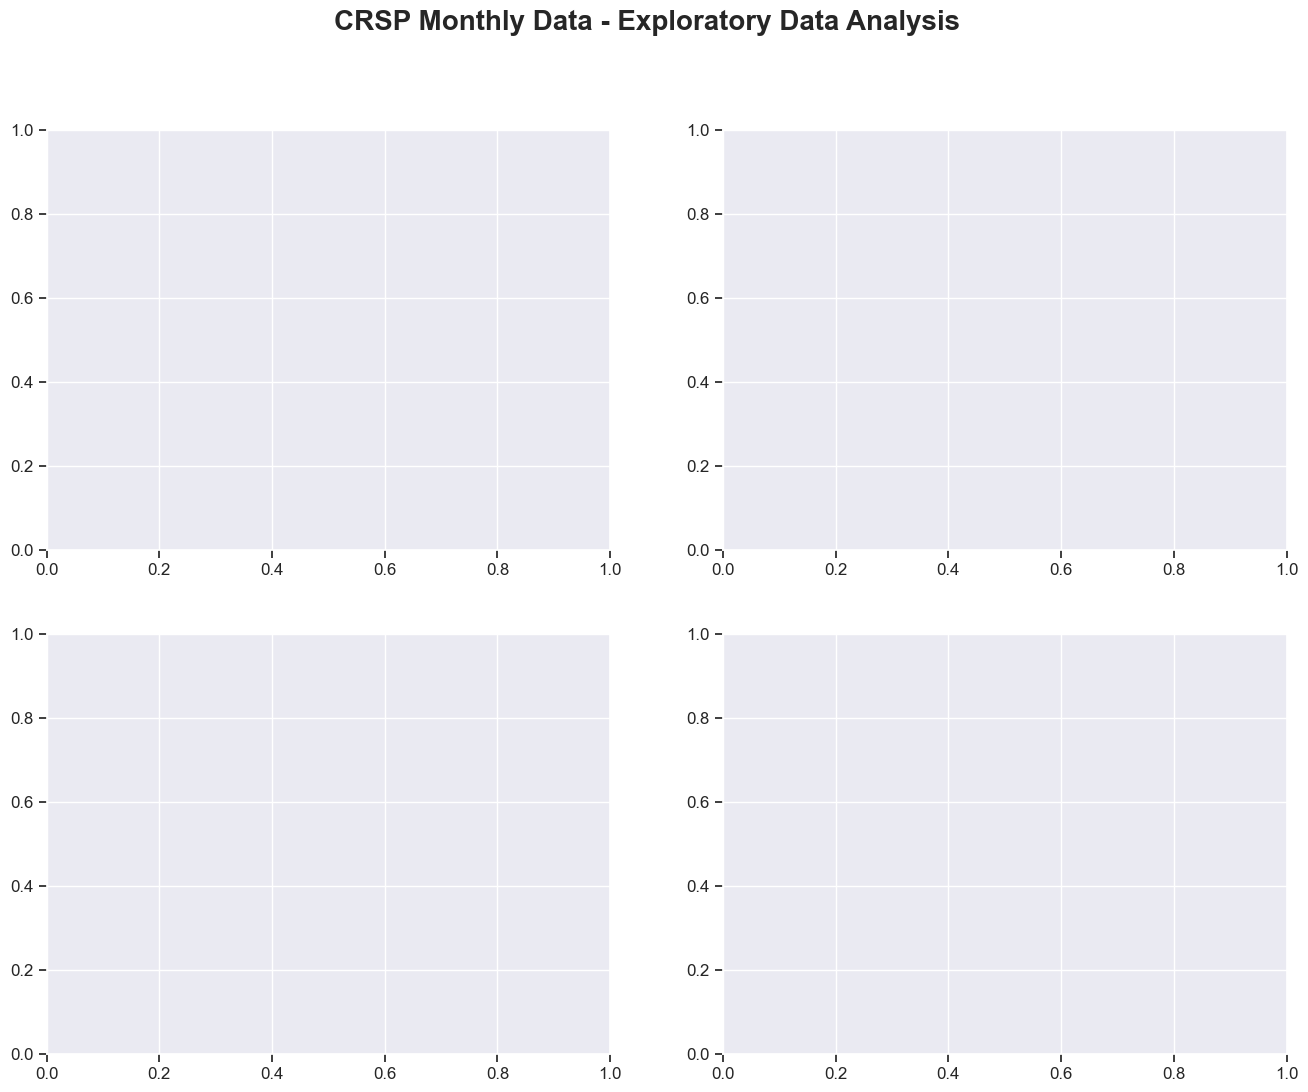

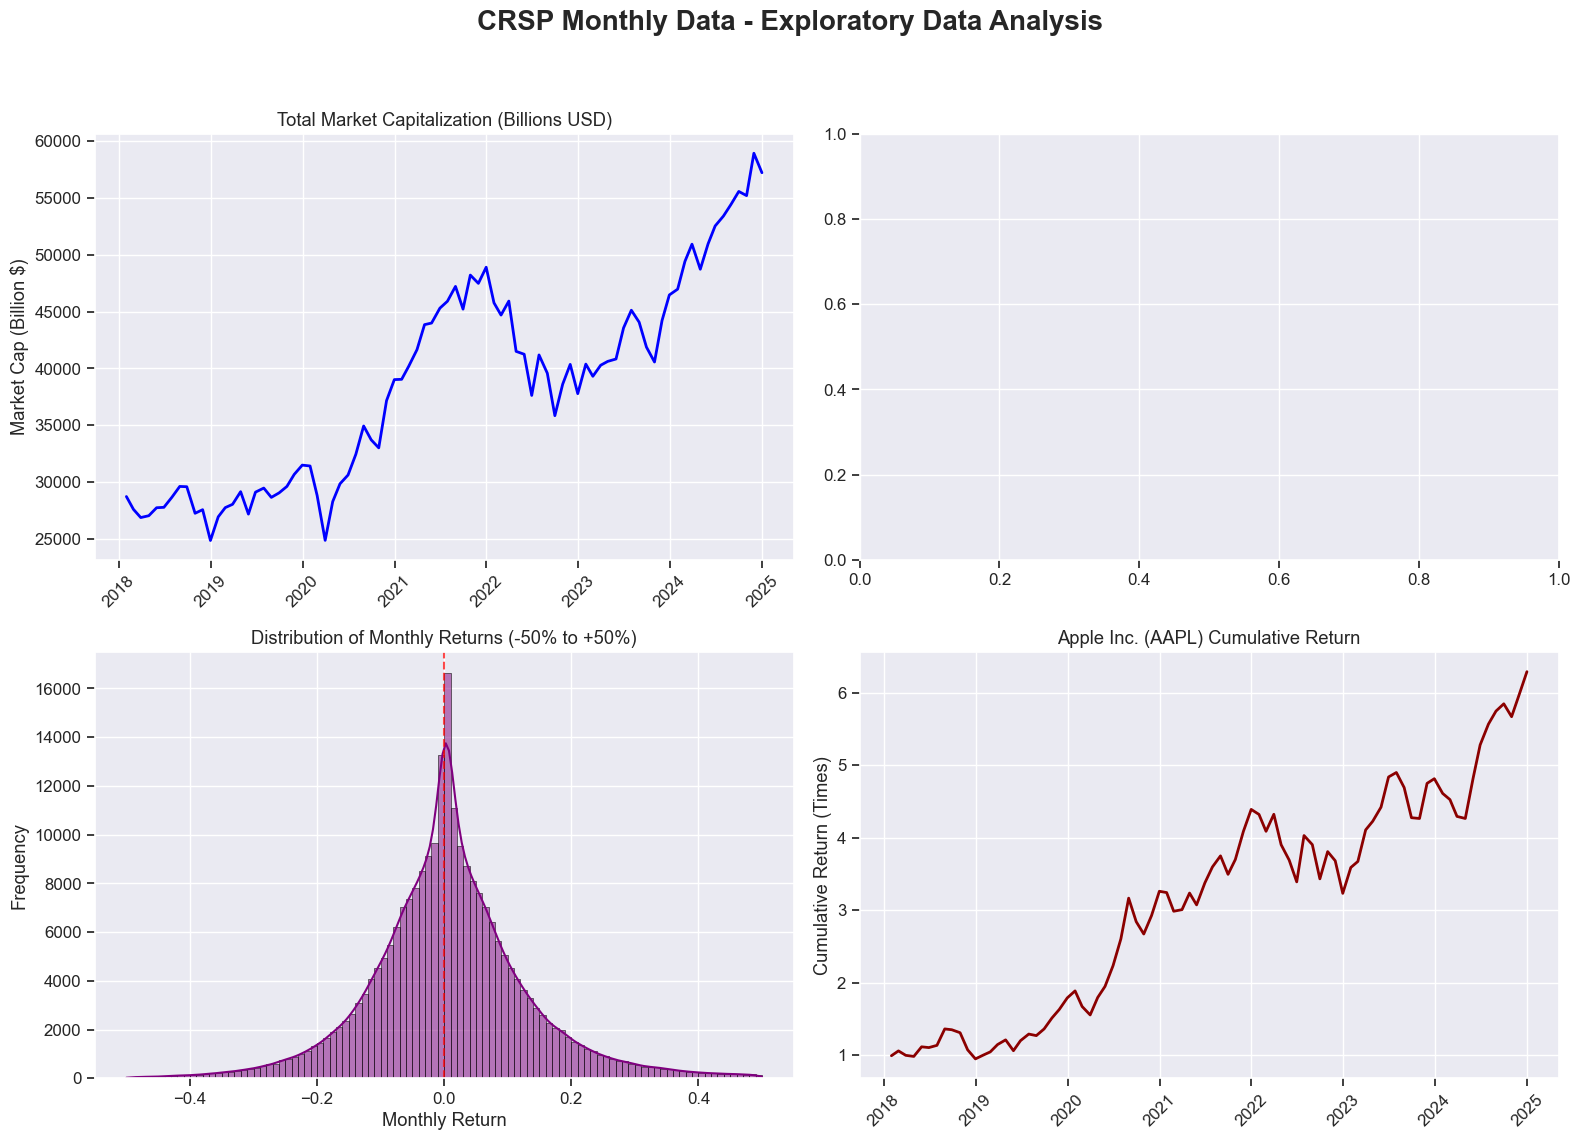

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CRSP Monthly Data - Exploratory Data Analysis', fontsize=20, fontweight='bold')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CRSP Monthly Data - Exploratory Data Analysis', fontsize=20, fontweight='bold')
print("Plotting Market Cap...")
# 按月加总所有股票的市值
monthly_mkt_cap = df.groupby('date')['mkt_cap'].sum() / 1e6 # 转换为十亿美元 (Billion)

axes[0, 0].plot(monthly_mkt_cap.index, monthly_mkt_cap.values, color='blue', linewidth=2)
axes[0, 0].set_title('Total Market Capitalization (Billions USD)')
axes[0, 0].set_ylabel('Market Cap (Billion $)')
axes[0, 0].tick_params(axis='x', rotation=45)
# 图 3: 月度收益率分布 (Distribution of Monthly Returns)
# ==========================================
print("Plotting Returns Distribution...")
# 剔除极端异常值以保证图表可读性 (比如把范围限制在 -50% 到 +50% 之间)
normal_returns = df[(df['ret'] > -0.5) & (df['ret'] < 0.5)]['ret']

sns.histplot(normal_returns, bins=100, kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Distribution of Monthly Returns (-50% to +50%)')
axes[1, 0].set_xlabel('Monthly Return')
axes[1, 0].set_ylabel('Frequency')
# 添加一条 0 的垂直虚线作为基准
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)
# 图 4: 个股抽样检查 - 苹果公司 (AAPL Sanity Check)
# ==========================================
print("Plotting Sample Stock (Apple Inc.)...")
# 找出包含 "APPLE" 的公司 (苹果的 PERMNO 通常是 14593)
apple_df = df[df['comnam'].astype(str).str.contains('APPLE INC', na=False)].sort_values('date')

if not apple_df.empty:
    # 计算累计收益率 (1+r) 的累乘
    apple_df['cum_ret'] = (1 + apple_df['ret']).cumprod()
    axes[1, 1].plot(apple_df['date'], apple_df['cum_ret'], color='darkred', linewidth=2)
    axes[1, 1].set_title('Apple Inc. (AAPL) Cumulative Return')
    axes[1, 1].set_ylabel('Cumulative Return (Times)')
    axes[1, 1].tick_params(axis='x', rotation=45)
else:
    axes[1, 1].text(0.5, 0.5, 'Apple Data Not Found\n(Check date range or filtering)', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Sample Stock Check')

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 为大标题留出空间
plt.show()
# print("✅ Visualization complete!")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 设置绘图风格，让图表看起来更专业
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.1)

# 2. 加载数据
print("Loading data...")
df = pd.read_csv("data/raw/crsp_monthly.csv")
df['date'] = pd.to_datetime(df['date'])

# 创建一个 2x2 的图表矩阵
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CRSP Monthly Data - Exploratory Data Analysis', fontsize=20, fontweight='bold')

# ==========================================
# 图 1: 美股总市值变化趋势 (Total Market Cap)
# ==========================================
print("Plotting Market Cap...")
# 按月加总所有股票的市值
monthly_mkt_cap = df.groupby('date')['mkt_cap'].sum() / 1e6 # 转换为十亿美元 (Billion)

axes[0, 0].plot(monthly_mkt_cap.index, monthly_mkt_cap.values, color='blue', linewidth=2)
axes[0, 0].set_title('Total Market Capitalization (Billions USD)')
axes[0, 0].set_ylabel('Market Cap (Billion $)')
axes[0, 0].tick_params(axis='x', rotation=45)

# ==========================================
# 图 2: 活跃股票数量变化 (Number of Active Stocks)
# ==========================================
print("Plotting Active Stocks Count...")
# 按月统计有多少只股票有交易数据
active_stocks = df.groupby('date')['permno'].count()

axes[0, 1].plot(active_stocks.index, active_stocks.values, color='green', linewidth=2)
axes[0, 1].set_title('Number of Active Common Stocks per Month')
axes[0, 1].set_ylabel('Stock Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# ==========================================
# 图 3: 月度收益率分布 (Distribution of Monthly Returns)
# ==========================================
print("Plotting Returns Distribution...")
# 剔除极端异常值以保证图表可读性 (比如把范围限制在 -50% 到 +50% 之间)
normal_returns = df[(df['ret'] > -0.5) & (df['ret'] < 0.5)]['ret']

sns.histplot(normal_returns, bins=100, kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Distribution of Monthly Returns (-50% to +50%)')
axes[1, 0].set_xlabel('Monthly Return')
axes[1, 0].set_ylabel('Frequency')
# 添加一条 0 的垂直虚线作为基准
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# ==========================================
# 图 4: 个股抽样检查 - 苹果公司 (AAPL Sanity Check)
# ==========================================
print("Plotting Sample Stock (Apple Inc.)...")
# 找出包含 "APPLE" 的公司 (苹果的 PERMNO 通常是 14593)
apple_df = df[df['comnam'].astype(str).str.contains('APPLE INC', na=False)].sort_values('date')

if not apple_df.empty:
    # 计算累计收益率 (1+r) 的累乘
    apple_df['cum_ret'] = (1 + apple_df['ret']).cumprod()
    axes[1, 1].plot(apple_df['date'], apple_df['cum_ret'], color='darkred', linewidth=2)
    axes[1, 1].set_title('Apple Inc. (AAPL) Cumulative Return')
    axes[1, 1].set_ylabel('Cumulative Return (Times)')
    axes[1, 1].tick_params(axis='x', rotation=45)
else:
    axes[1, 1].text(0.5, 0.5, 'Apple Data Not Found\n(Check date range or filtering)', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Sample Stock Check')

# 调整布局并显示
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 为大标题留出空间
plt.show()
print("✅ Visualization complete!")